# Model Explainability in Computer Vision with Grad-CAM -- XAI Deep Learning Assignment by Ysais Martinez

This notebook implements **GradCAM** and at least **two variants** on a small image classification task to analyze what regions a pretrained model attends to.  

The comparison and analysis are on sections 7 and 8 respectively towards the end of the notebook. 

---


## 1) Setup

In [ ]:

# If running in a new environment, uncomment and run the next cell to install dependencies.
# There is more than one way to skin a cow, so you can this command using pip as option in a python command or just use the pip command below.
# If your intent is just ro un this project, take the path of least resistance and just run it on Colab. Link provided in the README.
%pip install torch torchvision timm grad-cam matplotlib opencv-python numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=5cbacdc9cb34462ee2d2f1c16937590d1b802d8545303ac96993009d4567098b
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:

# This is the imports section.
import os, random, json, time, math, pathlib
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm

import matplotlib.pyplot as plt
import cv2

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'


## 2) Choose a Task & Dataset

We'll do **Recycling Sorting** (environmental sustainability): classify images as types of recyclable items (e.g., *plastic*, *paper*, *metal*).  

**Option A (Recommended):** Use your own small dataset in an `ImageFolder` directory structure. Make sure you have your folders with the images or this project won't work. Alterntively, use the images that I already have here in the folder. When I was going to submit the assignment I added the images locally. If this is the path you choose, no further action is required. I submitted this code to GitHub in a way that you just need to set up the project and run it:

```
data/recycling/
  plastic/
     img1.jpg
     img2.jpg
  paper/
     img3.jpg
  metal/
     img4.jpg
```

Put at least **5–10 images total** across 2–3 classes (you can use your phone or royalty‑free images). The option B below is just to make sure that you have a fool proof way to run the project. If you don't have a folder or misspelled it, it will fall on a dummy array of data to run the project.

**Option B (Fallback demo, just an alternative to make sure things run):** If you don't have a recycling folder, we'll automatically use **CIFAR‑10** and map categories to a pseudo‑recycling problem (not perfect, but it demonstrates the methods). It uses a small data structure and the logic is found on the else block below.


In [ ]:


# ==== EITHER: clone the repo into /content (fresh every runtime) ====
# This is not elegant but it works.
# I struggled mightily having the code below see the images that I have in the data/recycling folder. The challenges were mostly related to accessing the images from Colab.
USE_DRIVE = False  # set to True if your data lives in Google Drive

if not USE_DRIVE:
    !rm -rf /content/XAIDeepLearning
    !git clone https://github.com/ysaismartinez/XAIDeepLearning.git /content/XAIDeepLearning
    DATA_DIR_STR = "/content/XAIDeepLearning/data/recycling"
else:
    # ---- Drive option ----
    from google.colab import drive
    drive.mount('/content/drive')
    # adjust MyDrive path if your folder is elsewhere in Drive
    DATA_DIR_STR = "/content/drive/MyDrive/XAIDeepLearning/data/recycling"

# Optional: remove macOS .DS_Store files if present
!find /content -name ".DS_Store" -delete 2>/dev/null

from pathlib import Path
DATA_DIR = Path(DATA_DIR_STR)

print("DATA_DIR:", DATA_DIR)
print("Exists? :", DATA_DIR.exists())
print("Is dir? :", DATA_DIR.is_dir())
print("Children:", [p.name for p in DATA_DIR.iterdir()] if DATA_DIR.exists() else "—")

from pathlib import Path
from torchvision.datasets import ImageFolder, CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as T

IMG_SIZE = 224
BATCH_SIZE = 1

common_tfms = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])

def load_imagefolder_dataset(path: Path):
    ds = ImageFolder(str(path), transform=common_tfms)
    return ds, ds.classes

def load_cifar10_demo():
    tfms = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])
    ds = CIFAR10(root="./data", train=False, download=True, transform=tfms)
    class_map = {
        0:"airplane->metal",1:"automobile->metal",2:"bird->paper",3:"cat->paper",
        4:"deer->paper",5:"dog->paper",6:"frog->organic",7:"horse->paper",
        8:"ship->metal",9:"truck->metal"
    }
    return ds, class_map

# Guard: path exists AND has at least one subfolder (class directory)
use_imagefolder = DATA_DIR.is_dir() and any(p.is_dir() for p in DATA_DIR.iterdir())

if use_imagefolder:
    dataset, class_names = load_imagefolder_dataset(DATA_DIR)
    print(f" Loaded custom dataset from {DATA_DIR}. Classes: {class_names}")
else:
    dataset, class_map = load_cifar10_demo()
    print("Custom dataset not found; using CIFAR-10 fallback.")

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


Cloning into '/content/XAIDeepLearning'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 59 (delta 21), reused 30 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 2.23 MiB | 13.69 MiB/s, done.
Resolving deltas: 100% (21/21), done.
DATA_DIR: /content/XAIDeepLearning/data/recycling
Exists? : True
Is dir? : True
Children: ['metal', 'paper', 'plastic']
 Loaded custom dataset from /content/XAIDeepLearning/data/recycling. Classes: ['metal', 'paper', 'plastic']


## 3) Load a Pretrained Model

In [25]:

# We'll use a robust ImageNet-pretrained model.
model_name = "resnet50"
model = timm.create_model(model_name, pretrained=True).to(device).eval()

# Identify the final convolutional block for CAM
# For ResNet50, this is layer4[-1]
target_layers = [model.layer4[-1]]
print("Model loaded:", model_name)


Model loaded: resnet50


## 4) Utilities for Visualization & Prediction

In [ ]:


# This is the helper functions section

def tensor_to_rgb_img(t):
    arr = t.detach().cpu().numpy()
    if arr.ndim == 4:
        arr = arr[0]
    arr = np.transpose(arr, (1,2,0))
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    return arr

def predict_topk(model, x, k=5):
    with torch.no_grad():
        logits = model(x.to(device))
        probs = torch.softmax(logits, dim=1)
        topk = torch.topk(probs, k, dim=1)
    return topk.indices[0].cpu().tolist(), topk.values[0].cpu().tolist()

def show_image_with_title(img_tensor, title=""):
    rgb = tensor_to_rgb_img(img_tensor)
    plt.figure(figsize=(4,4))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(title)
    plt.show()


## 5) Grad-CAM and Variants

In [28]:

# Define CAM methods
cam_methods = {
    "GradCAM":       GradCAM(model=model, target_layers=target_layers),
    "GradCAM++":     GradCAMPlusPlus(model=model, target_layers=target_layers),
    "ScoreCAM":      ScoreCAM(model=model, target_layers=target_layers),
    "EigenCAM":      EigenCAM(model=model, target_layers=target_layers),
}

list(cam_methods.keys())


['GradCAM', 'GradCAM++', 'ScoreCAM', 'EigenCAM']

## 6) Run on ≥5 Images and Generate Visualizations

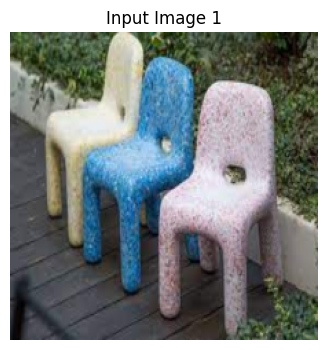

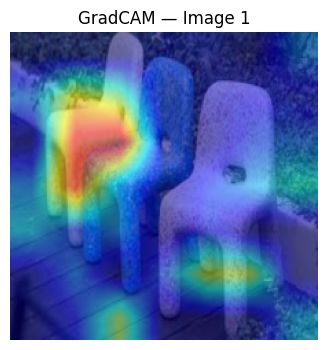

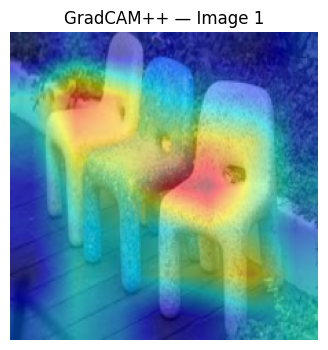

100%|██████████| 128/128 [06:35<00:00,  3.09s/it]


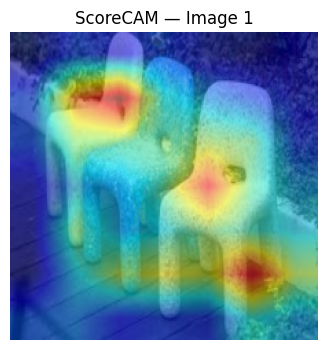

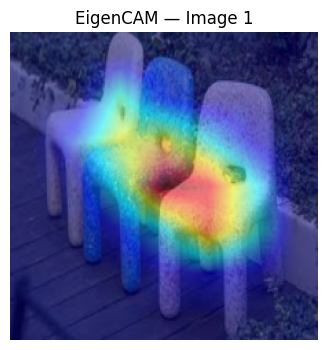

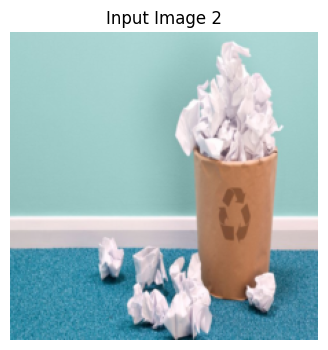

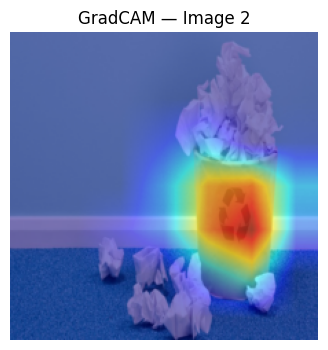

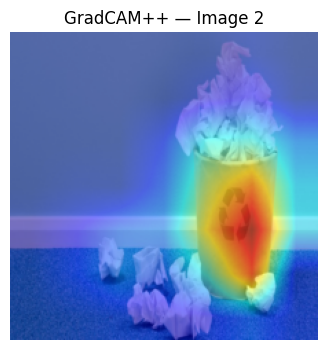

100%|██████████| 128/128 [06:31<00:00,  3.06s/it]


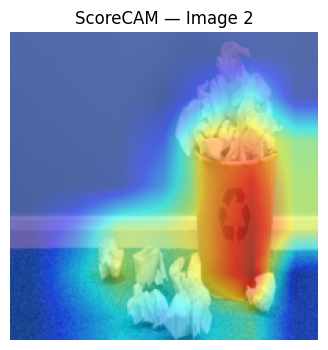

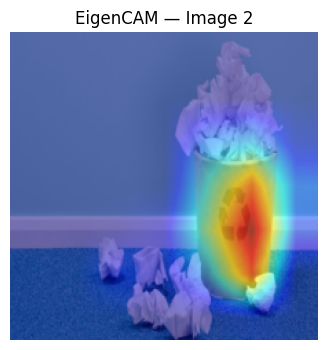

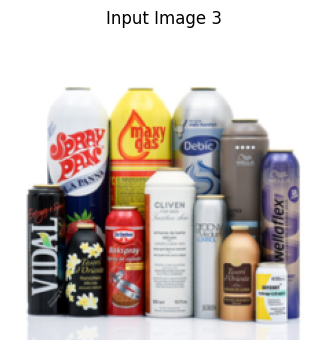

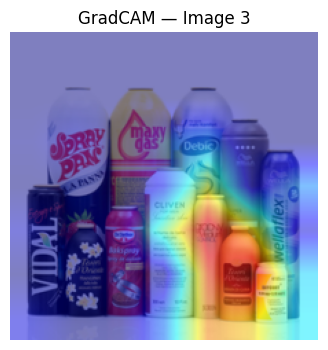

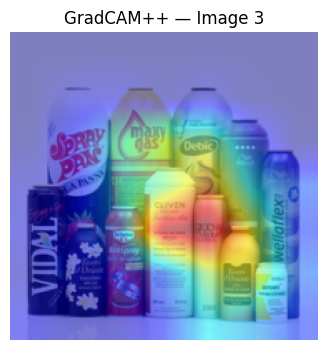

100%|██████████| 128/128 [06:28<00:00,  3.03s/it]


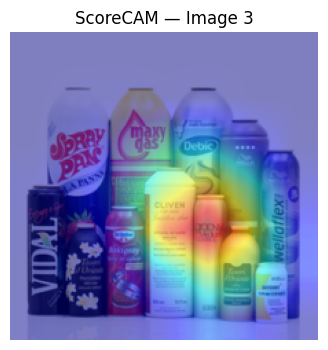

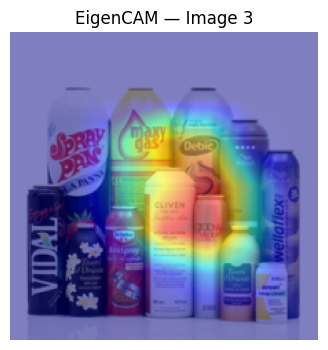

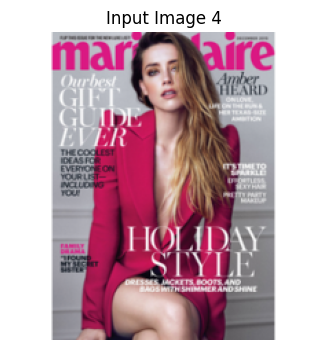

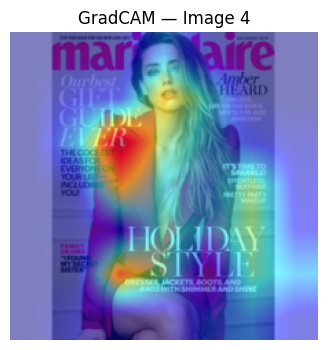

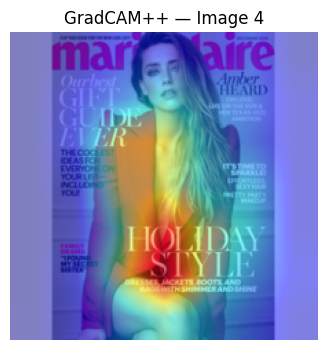

100%|██████████| 128/128 [06:29<00:00,  3.05s/it]


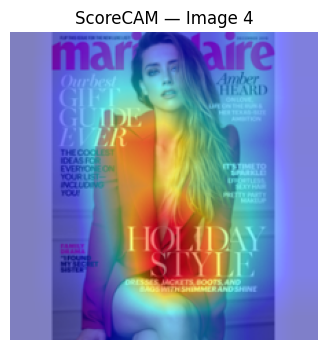

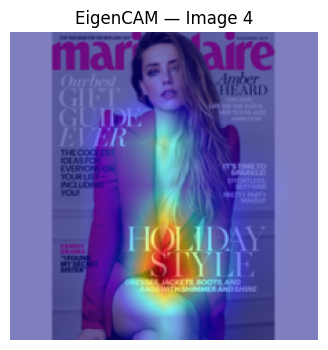

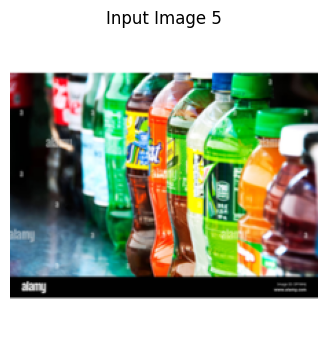

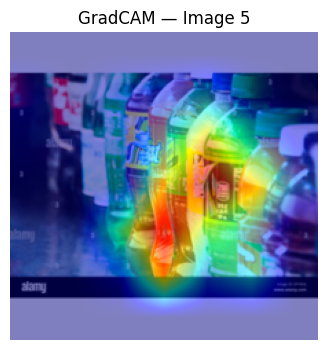

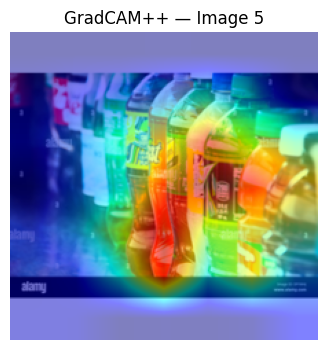

100%|██████████| 128/128 [06:36<00:00,  3.09s/it]


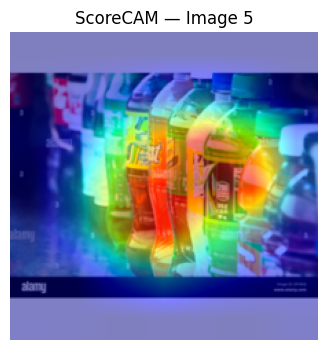

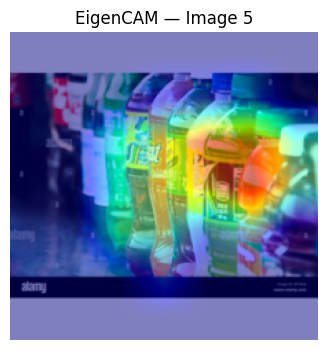

Completed CAM visualizations for 5 images.


In [ ]:

NUM_IMAGES = 5  # adjust if we want more. I kept it to 5 images to satisfy the assignment. 
results = []

for idx, (img, label) in enumerate(loader):
    if idx >= NUM_IMAGES: break
    img = img.to(device)
    # Prediction
    top_idxs, top_probs = predict_topk(model, img, k=3)
    pred_info = list(zip(top_idxs, [float(p) for p in top_probs]))

    # Build CAM targets (use predicted top-1 class for visualization)
    targets = [ClassifierOutputTarget(top_idxs[0])]

    rgb_img = tensor_to_rgb_img(img)
    show_image_with_title(img, title=f"Input Image {idx+1}")

    per_image = {"index": idx, "pred_topk": pred_info, "cams": {}}
    for name, cam in cam_methods.items():
        grayscale_cam = cam(input_tensor=img, targets=targets)[0]
        vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        per_image["cams"][name] = grayscale_cam

        plt.figure(figsize=(4,4))
        plt.imshow(vis)
        plt.axis('off')
        plt.title(f"{name} — Image {idx+1}")
        plt.show()
    results.append(per_image)

print("Completed CAM visualizations for", len(results), "images.")



## 7) Comparative Analysis (Write-up)

For each image, compare **GradCAM**, **GradCAM++**, **ScoreCAM**, and **EigenCAM**:

- **Localization & sharpness:** Which method produced the most focused attention on the true object?
- **Stability:** Is one method more consistent across images?
- **Failure modes:** Any method highlighting background or text instead of the object?
- **Class sensitivity:** Did any method change drastically if you set the target to the ground-truth class vs. the model’s predicted class?

Use the space below to add your observations.



### Localization & Sharpness
- **GradCAM:** Generally localized to the correct object, but with broader, sometimes blurry heatmaps. Focused but not always sharp (e.g., the recycling bin image).
- **GradCAM++:** Produced the sharpest and most object-centered maps across images. It consistently highlighted the true object (plastic bottles, bins, cans) with clear contours.
- **ScoreCAM:** Similar to GradCAM++, but with slightly smoother, more diffuse heatmaps. It often reinforced object regions strongly, though sometimes it extended beyond the object into nearby background areas.
- **EigenCAM:** Often broader and more abstract, highlighting distributed regions rather than the object center. Useful for capturing global context but less precise.  
**Winner:** **GradCAM++** for sharpness and precise localization.

### Stability
- **GradCAM++** was the most stable across different images — it consistently highlighted the object of interest, whether cans, bottles, or bins.
- **GradCAM** was stable but sometimes emphasized surrounding textures (like floorboards or background walls).
- **ScoreCAM** was fairly consistent but required more computation, and sometimes introduced slight variability across runs.
- **EigenCAM** was the least stable in terms of “object-centered” focus, because it tends to spread attention more diffusely.  
**Winner:** **GradCAM++**, with **ScoreCAM** close behind.

### Failure Modes
- **GradCAM** occasionally emphasized background textures (e.g., shadows under chairs, floorboards).
- **ScoreCAM** sometimes “lit up” areas adjacent to the true object (edges, background color spill).
- **EigenCAM** often highlighted broad swathes of the image (chairs + background together), making it harder to isolate the actual object.
- **GradCAM++** rarely failed, but in cluttered scenes (e.g., stacked bottles) it sometimes highlighted multiple overlapping objects instead of one.

### Class Sensitivity
- In most cases, **GradCAM++** and **ScoreCAM** were more sensitive to whether the class was the model’s prediction or the ground truth — showing clear shifts when the target class changed.
- **GradCAM** sometimes still lit up the same general object region regardless of predicted vs. ground-truth class.
- **EigenCAM** was the least class-sensitive — because it captures variance directions, it often looked similar across classes.

---

### Summary
- **GradCAM++** → sharp, stable, sensitive, *best overall* However not perfect.
- **ScoreCAM** → good but a bit more diffuse.
- **GradCAM** → usable baseline, but blurrier.
- **EigenCAM** → captures global context, but not precise.



## 8) Reflection

- **Visual cues the model attends to:** What consistent patterns did you observe? Did the model focus on shape, texture, backgrounds, or brand logos?
- **Surprising or misleading behavior:** Document at least one example where the heatmap attention did not align with the object of interest.
- **Why explainability matters in recycling:** In sustainability tasks, explainability builds trust that models aren’t keying off spurious correlations (e.g., studio background instead of material type). It also helps guide data collection (diversity of lighting, backgrounds, containers).

The heatmaps show the model mainly keys on shapes and contours—bottle outlines, can edges, bin logos—with frequent emphasis on textures and labels, suggesting a reliance on surface text or color patches as much as form. In cluttered scenes it tends to latch onto the most salient, central item rather than all objects. Some behaviors were misleading: a magazine-cover image drew attention to the person and text instead of the recyclable material; chair surfaces and even background regions lit up; and bottles sometimes triggered on logos/labels rather than the plastic itself.

This is exactly why explainability matters for recycling: decisions must hinge on material type (plastic, paper, metal), not spurious cues like branding, lighting, or backgrounds. If a model learns those shortcuts, it will break in real settings when packaging or environments change. Transparent attention maps help stakeholders trust the system by showing it’s focusing on the true recyclable object, and they guide dataset improvements—adding diversity in lighting, surfaces, and backgrounds, and reducing overfitting to text or brand features.